## Unsupervised Lexicon-based Sentiment Analysing using with Tiktok comments about "Hhouse Building Ireland"
references :
* https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/
* https://medium.com/@mohammed97ashraf/unsupervised-lexical-models-for-sentiment-prediction-using-python-e01576e8c9a6
* https://towardsdatascience.com/unsupervised-semantic-sentiment-analysis-of-imdb-reviews-2c5f520fbf81
* https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/

Data preprocessing steps:

Cleaning the text
Tokenization
Enrichment – POS tagging
Stopwords removal
Obtaining the stem words

In [29]:
import pandas as pd
import numpy as np
import nltk

#connect database
import mysql.connector 
from mysql.connector import Error

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings


from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('sentiwordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
import string
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
import re

## lexicons
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn

## visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akermen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/akermen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/akermen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/akermen/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


### Get data from MySQL database
* Dataset was obtained from tiktok platform using selenium library. More detailed information and scraping method are explained in "scraper.ipynb" notebook.

In [2]:
## get tiktok reviews about irelan housing building data from mysql db
#db connections
def get_connection():
    return mysql.connector.connect(host='127.0.0.1',
                                   user='root',
                                   password='',
                                   charset="utf8mb4")
# get data
def get_data(query):
    try:
        connection = get_connection()
        if connection.is_connected():
            cursor = connection.cursor()
            cursor.execute("USE assesment;")
            cursor.execute(query)
            cols = list(map(lambda x: x[0], cursor.description))
            #result_list=cursor.fetchall()
    except Exception as e:
            print("Query is failed")
    df=pd.DataFrame(cursor.fetchall(),columns=cols)
    return df

query="""select * from comments; """

df=get_data(query)
df.head()



,keyword,video_url,content,comment,authors_name,comment_date
0,None,https://www.tiktok.com/@karll1994/video/699291...,Full House Tour floor is in plastering is done ✅,under floor heating is great until breaks down...,Jp Lynch,2021-8-5
1,None,https://www.tiktok.com/@karll1994/video/699291...,Full House Tour floor is in plastering is done ✅,Is it bad that I instantly thought that your w...,Grace,2021-8-20
2,None,https://www.tiktok.com/@karll1994/video/699291...,Full House Tour floor is in plastering is done ✅,beautiful house can't wait to see it when its ...,Gavin606,2021-8-6
3,None,https://www.tiktok.com/@karll1994/video/699291...,Full House Tour floor is in plastering is done ✅,They windows from Poland ?,Mark hislop,2021-8-5
4,None,https://www.tiktok.com/@karll1994/video/699291...,Full House Tour floor is in plastering is done ✅,we have under floor heating in the house 22 ye...,Patrick Burke,2021-8-6


In [3]:
X=df["comment"]
X.head(10)

0    under floor heating is great until breaks down...
1    Is it bad that I instantly thought that your w...
2    beautiful house can't wait to see it when its ...
3                           They windows from Poland ?
4    we have under floor heating in the house 22 ye...
5    Super looking home best of luck with your new ...
6    beautiful . may you have a life time of loving...
7    what size steel did you use over slider ?\nlov...
8    this is beautiful 😍 we are at very start of se...
9                     guys help me quit college please
Name: comment, dtype: object

In [4]:
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

### 1- Cleaning the texts

In [5]:
cleaned_data=[]

# For loop from first value to length(X), ^a-zA-Z means include small and capital case letters

for i in range(len(X)):
    review = re.sub('[^a-zA-Z]', ' ',X.iloc[i])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if (word not in stop_words) and (word not in punct)]
    review = ' '.join(review)
    cleaned_data.append(review)

df_2=pd.DataFrame(cleaned_data,columns=['comment'])
df_2.head()


,comment
0,floor heat great break contractor seen look go...
1,bad instantli thought window perfect sneak mis...
2,beauti hous wait see done
3,window poland
4,floor heat hous year bother seriou job


### 2- tokinize, stopwords and OS tag


In [6]:
# POS tagger dictionary

pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df_2['POS_tag'] = df_2['comment'].apply(token_stop_pos)
df_2.head()

,comment,POS_tag
0,floor heat great break contractor seen look go...,"[(floor, n), (heat, n), (great, a), (break, n)..."
1,bad instantli thought window perfect sneak mis...,"[(bad, a), (instantli, n), (thought, v), (wind..."
2,beauti hous wait see done,"[(beauti, r), (hous, a), (wait, n), (see, v), ..."
3,window poland,"[(window, n), (poland, n)]"
4,floor heat hous year bother seriou job,"[(floor, n), (heat, n), (hous, a), (year, n), ..."


### 3-  Lemmatization

In [7]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew
    
df_2['lemma'] = df_2['POS_tag'].apply(lemmatize)
df_2.head()

,comment,POS_tag,lemma
0,floor heat great break contractor seen look go...,"[(floor, n), (heat, n), (great, a), (break, n)...",floor heat great break contractor see look g...
1,bad instantli thought window perfect sneak mis...,"[(bad, a), (instantli, n), (thought, v), (wind...",bad instantli think window perfect sneak mis...
2,beauti hous wait see done,"[(beauti, r), (hous, a), (wait, n), (see, v), ...",beauti hous wait see do
3,window poland,"[(window, n), (poland, n)]",window poland
4,floor heat hous year bother seriou job,"[(floor, n), (heat, n), (hous, a), (year, n), ...",floor heat hous year bother seriou job


## Vader

In [8]:
df_final=df_2[['comment','lemma']]

In [9]:
analyzer= SentimentIntensityAnalyzer()
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df_final['vader'] = df_final['lemma'].apply(vadersentimentanalysis)
df_final.head()

,comment,lemma,vader
0,floor heat great break contractor seen look go...,floor heat great break contractor see look g...,0.6249
1,bad instantli thought window perfect sneak mis...,bad instantli think window perfect sneak mis...,0.3818
2,beauti hous wait see done,beauti hous wait see do,0.0000
3,window poland,window poland,0.0000
4,floor heat hous year bother seriou job,floor heat hous year bother seriou job,-0.3400


## TextBlob

In [10]:
# get subjectivity score from lemma , if score >0 positive, score <0 negative and score =0 neutral
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

df_final['Textblob']=df_final['lemma'].apply(getSubjectivity)
df_final.head()

,comment,lemma,vader,Textblob
0,floor heat great break contractor seen look go...,floor heat great break contractor see look g...,0.6249,0.750000
1,bad instantli thought window perfect sneak mis...,bad instantli think window perfect sneak mis...,0.3818,0.833333
2,beauti hous wait see done,beauti hous wait see do,0.0000,0.000000
3,window poland,window poland,0.0000,0.000000
4,floor heat hous year bother seriou job,floor heat hous year bother seriou job,-0.3400,0.000000


## SentiWordNet

In [13]:
def get_sentiment_score(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
    return sentiment

df_final['swn'] = df_2['POS_tag'].apply(get_sentiment_score)
df_final.head()

,comment,lemma,vader,Textblob,swn
0,floor heat great break contractor seen look go...,floor heat great break contractor see look g...,0.6249,0.750000,0.000
1,bad instantli thought window perfect sneak mis...,bad instantli think window perfect sneak mis...,0.3818,0.833333,0.375
2,beauti hous wait see done,beauti hous wait see do,0.0000,0.000000,0.000
3,window poland,window poland,0.0000,0.000000,0.000
4,floor heat hous year bother seriou job,floor heat hous year bother seriou job,-0.3400,0.000000,0.000


In [32]:
### named scores positive, negative and neutral
# vader
def vader_final(score):
    if score >= 0.5:
        return 'Positive'
    elif score <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

#textblob and swn
def text_swn_final(score):
    if score > 0:
        return 'Positive'
    elif score <0 :
        return 'Negative'
    else:
        return 'Neutral'
    
df_final['vader_sentiment']=df_final['vader'].apply(vader_final)
df_final['TextBlob_sentiment']=df_final['Textblob'].apply(text_swn_final)
df_final['swn_sentiment']=df_final['swn'].apply(text_swn_final)

df_final.head(10)


,comment,lemma,vader,Textblob,swn,vader_sentiment,TextBlob_sentimen,swn_sentiment,TextBlob_sentiment
0,floor heat great break contractor seen look go...,floor heat great break contractor see look g...,0.6249,0.750000,0.000,Positive,Positive,Neutral,Positive
1,bad instantli thought window perfect sneak mis...,bad instantli think window perfect sneak mis...,0.3818,0.833333,0.375,Neutral,Positive,Positive,Positive
2,beauti hous wait see done,beauti hous wait see do,0.0000,0.000000,0.000,Neutral,Neutral,Neutral,Neutral
3,window poland,window poland,0.0000,0.000000,0.000,Neutral,Neutral,Neutral,Neutral
4,floor heat hous year bother seriou job,floor heat hous year bother seriou job,-0.3400,0.000000,0.000,Neutral,Neutral,Neutral,Neutral
5,super look home best luck new home,super look home best luck new home,0.9022,0.473737,1.500,Positive,Positive,Positive,Positive
6,beauti may life time love memori,beauti may life time love memori,0.6369,0.600000,0.500,Positive,Positive,Positive,Positive
7,size steel use slider love hous,size steel use slider love hous,0.6369,0.600000,0.250,Positive,Positive,Positive,Positive
8,beauti start self build think stori see could ...,beauti start self build think stori see coul...,0.2732,0.000000,0.375,Neutral,Neutral,Positive,Neutral
9,guy help quit colleg pleas,guy help quit colleg plea,0.4019,0.000000,0.375,Neutral,Neutral,Positive,Neutral


In [33]:
### calculate value counts for each lexicons and display for comparing
v_counts = df_final['vader_sentiment'].value_counts()
swn_counts=df_final['swn_sentiment'].value_counts()
t_counts=df_final['TextBlob_sentimen'].value_counts()

print("vader results :" ,v_counts)
print("swn results :", swn_counts)
print("TextBlob analyresultssis :", t_counts)

vader results : Neutral     2315
Positive     516
Negative      74
Name: vader_sentiment, dtype: int64
swn results : Neutral     1575
Positive     892
Negative     438
Name: swn_sentiment, dtype: int64
TextBlob analyresultssis : Neutral     1741
Positive    1164
Name: TextBlob_sentimen, dtype: int64


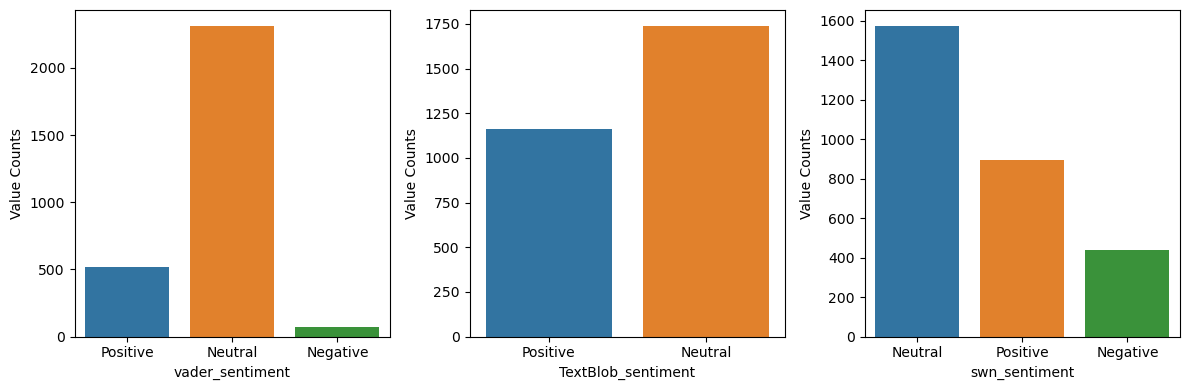

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot vader_sentiment
sns.countplot(ax=axes[0], x='vader_sentiment', data=df_final)
axes[0].set_xlabel('vader_sentiment')
axes[0].set_ylabel('Value Counts')

# Plot TextBlob_sentiment
sns.countplot(ax=axes[1], x='TextBlob_sentiment', data=df_final)
axes[1].set_xlabel('TextBlob_sentiment')
axes[1].set_ylabel('Value Counts')

# Plot swn_sentiment
sns.countplot(ax=axes[2], x='swn_sentiment', data=df_final)
axes[2].set_xlabel('swn_sentiment')
axes[2].set_ylabel('Value Counts')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

### 
The results look quite different from each other.There is no control observation comparable to classical machine learning techniques.In this case, let's examine a few examples

In [42]:
test_1=df_final[(df_final['vader_sentiment']=='Neutral')& ((df_final['swn_sentiment']!='Neutral')|(df_final['TextBlob_sentiment']!='Neutral'))]
test_1.head(10)

,comment,lemma,vader,Textblob,swn,vader_sentiment,TextBlob_sentimen,swn_sentiment,TextBlob_sentiment
1,bad instantli thought window perfect sneak mis...,bad instantli think window perfect sneak mis...,0.3818,0.833333,0.375,Neutral,Positive,Positive,Positive
8,beauti start self build think stori see could ...,beauti start self build think stori see coul...,0.2732,0.000000,0.375,Neutral,Neutral,Positive,Neutral
9,guy help quit colleg pleas,guy help quit colleg plea,0.4019,0.000000,0.375,Neutral,Neutral,Positive,Neutral
14,nice,nice,0.4215,1.000000,0.875,Neutral,Positive,Positive,Positive
17,beauti wait see finish well done,beauti wait see finish well do,0.2732,0.000000,0.375,Neutral,Neutral,Positive,Neutral
23,near kinnegad think lol,near kinnegad think lol,0.4215,0.550000,0.000,Neutral,Positive,Neutral,Positive
26,absolut stun home,absolut stun home,0.0000,0.000000,-0.125,Neutral,Neutral,Negative,Neutral
29,pass hous everyday,pas hous everyday,0.0000,0.600000,0.000,Neutral,Positive,Neutral,Positive
30,fabul wait see like finish,fabul wait see like finish,0.3612,0.000000,-0.125,Neutral,Neutral,Negative,Neutral
35,want,want,0.0772,0.000000,-0.250,Neutral,Neutral,Negative,Neutral
